In [1]:
import os

import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm

ver = f'17.0-2024-03-15' # version of the dataset

2.3.0.dev20240311
2.2.0.dev20240311


In [50]:
# helper functions (from https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py)

from IPython.display import Audio
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

torch.random.manual_seed(50)

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


In [14]:
# go to dataset directory
path = f'~/dataset/cv-corpus-{ver}/en'

In [15]:
# read validated audio file table
tqdm.pandas()
#df = pd.read_csv(f"{path}/validated.tsv", sep='\t').progress_applymap(lambda x: x.strip() if isinstance(x, str) else x)
# get x percent of the data
df = pd.read_csv(f"{path}/validated.tsv", sep='\t')
df_size = pd.read_csv(f"{path}/clip_durations.tsv", sep='\t')

/var/folders/gn/xf43f2vs2172cb2qv27vz6100000gn/T/ipykernel_3414/3871038451.py:5: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{path}/validated.tsv", sep='\t')


In [16]:
df = df.drop(['client_id', 'sentence_id', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment'], axis=1)

In [4]:
import torch
import torchaudio
import torchaudio.transforms as T
import pandas as pd
from tqdm import tqdm

ROOT_DIR = '/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/'
# create new empty dataframe
df = pd.read_csv(f"{ROOT_DIR}/validated.tsv", sep='\t')
df = df.drop(['client_id', 'sentence_id', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment'], axis=1)

df_save = pd.DataFrame(columns = ['name', 'sentence'])

# define the threshold values
SR_THRESHOLD = 32e3 # Hz
DURATION_THRESHOLD = 10 # s

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 80

mel_spectrogram = T.MelSpectrogram(
        sample_rate=SR_THRESHOLD,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=n_mels,
        mel_scale="htk",
    )

# iterate over the initial dataframe
for i in tqdm(range(1), desc='Processing audio files...'):
    filename = df['path'][i].split('.')[0]
    sentence = df['sentence'][i]
    path = ROOT_DIR + 'clips/' + filename + '.mp3'
    
    audio, sr = torchaudio.load(uri=path, normalize=True, format='mp3')
    duration = audio.shape[-1] / sr
    if duration > DURATION_THRESHOLD:
        continue
    audio = torch.nn.functional.pad(audio, (0, sr * DURATION_THRESHOLD - audio.shape[-1]))
    if sr != SR_THRESHOLD:
        resampler = T.Resample(orig_freq=sr, new_freq=SR_THRESHOLD)
        audio = resampler(audio)
        
    duration = audio.shape[-1] / SR_THRESHOLD
    

    melspec = mel_spectrogram(audio)

    # save the melspec tensor
    path = ROOT_DIR + 'melspecs/' + filename + '.pt'
    torch.save(melspec, path)

    new_row = {'name': [filename + '.pt'], 'sentence': [sentence]}

    # add the new row to the new dataframe df_new
    df_save = pd.concat([df_save, pd.DataFrame(new_row)], ignore_index=True)
    
df_save.to_csv(ROOT_DIR + 'validated_cleaned_test.tsv', index=False, sep='\t')
df_save.head()

/var/folders/gn/xf43f2vs2172cb2qv27vz6100000gn/T/ipykernel_12112/2538168952.py:9: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{ROOT_DIR}/validated.tsv", sep='\t')
Processing audio files...: 100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


,name,sentence
0,common_voice_en_27710027.pt,"Joe Keaton disapproved of films, and Buster al..."


In [12]:
import pandas as pd
ROOT_DIR = '/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/'

df_save = pd.read_csv(ROOT_DIR + 'validated_cleaned.tsv', sep='\t')

In [23]:
nb_b = len(df_save)*197e3
print(len(df_save))
print(nb_b*1e-9)
print((361-212)/14)

1787991
352.23422700000003
10.642857142857142


In [22]:
import os
_, _, files = next(os.walk(ROOT_DIR + 'melspecs'))
file_count = len(files)
print(file_count)

1787991


In [94]:
Audio(audio.numpy(), rate=SR_THRESHOLD)
melspec.shape

torch.Size([1, 80, 626])

In [10]:
df.rename(columns={'path': 'clip'}, inplace=True)
df_final = pd.merge(df, df_size, on='clip', how='inner')
df_final['clip'] = df_final['clip'].apply(lambda x: x.split('.')[0] + '.pt')

,clip,sentence,duration[ms]
0,common_voice_en_27710027.pt,"Joe Keaton disapproved of films, and Buster al...",6300
1,common_voice_en_699711.pt,She'll be all right.,2184
2,common_voice_en_21953345.pt,six,6576
3,common_voice_en_18132047.pt,All's well that ends well.,4176
4,common_voice_en_27340672.pt,It is a busy market town that serves a large s...,6660


In [13]:
df_final.to_csv(f"{path}/validated_cleaned.tsv", sep='\t', index=False)

In [12]:
print(len(df_final['duration[ms]']))
df_final = df_final[df_final['duration[ms]'] < 10000]
print(len(df_final['duration[ms]']))

1798922
1787991


In [16]:
from deepspeech import *
from tqdm import tqdm

root_dir = f"/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/"

# load the dataset
train_data = CommonVoiceDataset(root_dir=root_dir, mode='train')
print(train_data.__len__())
count = 0
for i in tqdm(range(train_data.__len__() - 1)):
    data, _ = train_data.__getitem__(i)
    if data.shape[-1] > 626:
        count = count + 1

print(f'number of unpadded data: {count}')

1072794


100%|██████████| 1072793/1072793 [16:42<00:00, 1070.17it/s]

number of unpadded data: 747337


In [92]:
# pad all audio files to 10 seconds
def pad_audio(audio, sr, duration=10):
    audio = torch.nn.functional.pad(audio, (0, sr * duration - audio.shape[-1]))
    return audio

# load audio file
def load_audio(path, duration=10):
    status = False
    audio, sr = torchaudio.load(uri=path, normalize=True, format='mp3')
    audio_duration = audio.shape[-1] / sr
    if audio_duration < duration:
        status = True
        audio = pad_audio(audio, sr, duration)

    return audio, sr, status

# compute the mel spectrogram of the waveform
def get_audio_features(audio, sr, path, clipname, **kwargs):
    n_fft = kwargs.get('n_fft', 1024)
    win_length = kwargs.get('win_length', None)
    hop_length = kwargs.get('hop_length', 512)
    n_mels = kwargs.get('n_mels', 80)

    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
        norm="slaney",
        n_mels=n_mels,
        mel_scale="htk",
    )

    melspec = mel_spectrogram(audio)

    # split clipname to get the clip name
    melspec_name = clipname.split('.')[0] + '.pt'

    # save the melspec tensor
    full_path = os.path.expanduser(f"{path}/melspecs/{melspec_name}")
    torch.save(melspec, full_path)
        
    return melspec


In [60]:
# load a random audio file
try:
     df_final.head()
except:
    df_final = pd.read_csv(f"{path}/validated_size.tsv", sep='\t')

# choose a random audio file
i = torch.randint(len(df_final), (1,)).item()

sentence = df_final['sentence'].iloc[i]
filename = f"{path}/clips/{df_final['clip'].iloc[i]}"
full_path = os.path.expanduser(filename)

In [61]:
print(filename)
print(full_path)

~/dataset/cv-corpus-17.0-2024-03-15/en/clips/common_voice_en_32104909.mp3
/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/clips/common_voice_en_32104909.mp3


In [93]:
# load the audio file
for i in range(len(df_final)):
    sentence = df_final['sentence'].iloc[i]
    filename = f"{path}/clips/{df_final['clip'].iloc[i]}"
    full_path = os.path.expanduser(filename)
    
    SPEECH_WAVEFORM, SAMPLE_RATE = load_audio(full_path, duration=10)   
    melspec = get_audio_features(SPEECH_WAVEFORM, SAMPLE_RATE, path, df_final['clip'].iloc[i])


In [84]:
# load a all the .pt files in the melspecs directory
melspecs_filenames = []
for root, dirs, files in os.walk(os.path.expanduser(f"{path}/melspecs/")):
    print(len(files))
    for file in files:
        melspecs_filenames.append(os.path.join(root, file))

# load the melspecs
melspecs = [torch.load(melspec) for melspec in melspecs_filenames]

17899


In [85]:
melspecs

[tensor([[[4.1417e-15, 8.0031e-13, 4.1508e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [3.5766e-15, 7.5138e-13, 4.5454e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.1553e-16, 4.3766e-13, 5.9071e-06,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0815e-24, 1.7019e-22, 5.7187e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.0372e-24, 1.9967e-22, 4.4869e-16,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.0865e-25, 2.4192e-22, 1.0631e-15,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]]]),
 tensor([[[7.1072e-19, 9.4004e-15, 8.4396e-08,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2398e-18, 1.0899e-14, 9.5981e-08,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.2095e-18, 1.6771e-14, 1.4008e-07,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.3191e-27, 1.6430e-23, 6.3492e-18,  ..., 0.000

In [36]:
print(sentence)
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE, autoplay=True)

Its county seat is Burnsville.


In [ ]:
# compute the mel spectrogram of the waveform
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 80

mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

In [ ]:
import numpy as np
print(melspec.shape)
print(SPEECH_WAVEFORM.shape)
print(320000/(n_fft//2))

torch.Size([1, 80, 626])
torch.Size([1, 320000])
625.0
1024


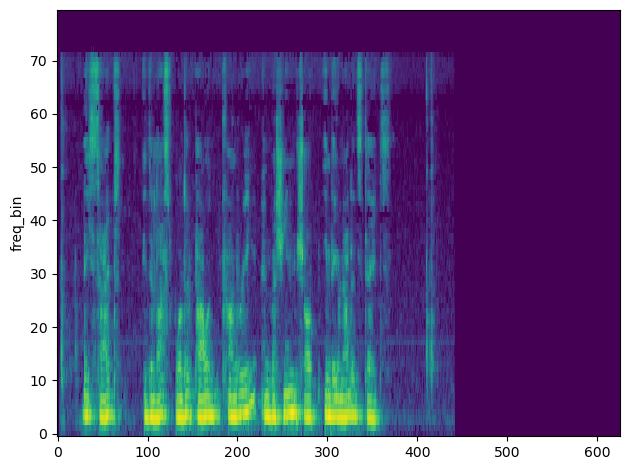

In [ ]:
#fig, axis = plt.subplots(1, 1, figsize=(4, 4))
fig, axis = plt.subplots(1, 1)
plot_spectrogram(melspec[0], ax=axis)

fig.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np

import torchaudio
import torchaudio.functional as FA
import torchaudio.transforms as T

from transformers import GPT2Model, GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, pipeline
import loralib as lora


# parameters
n_mels = 80
n_embedding = 512
n_blocks = 5
n_t = int(322/2) # TO DEFINE
dropout = .3
n_heads = 8
lora_dim = 32

class FeedForward(nn.Module):
    ''' Feed Forward Module '''
    def __init__(self, input_size, output_size, hidden_sizes):
        super(FeedForward, self).__init__()
        layers = []
        input_dim = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.GELU())
            input_dim = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)
    
    
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embedding, head_size, bias=False)
        self.query = nn.Linear(n_embedding, head_size, bias=False)
        self.value = nn.Linear(n_embedding, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(n_t, n_t))) # constant accessible (not trainable)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, n_t, n_embedding = x.shape

        # (n_embedding, head_size) * B, ith, n_embedding -> B, ith, head_size
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2, -1) * n_embedding ** -0.5 # divide by the square root of the size of the embedding
        wei = wei.masked_fill(self.tril[:n_t, :n_t] == 0, float("-inf"))
        wei = F.softmax(wei, dim=1)

        wei = self.dropout(wei)

        v = self.value(x)
        h = wei @ v # B, n_t, n_t @ B, n_t, head_size := B, n_t, head_size
        return h
    
class MultiHead(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embedding, n_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h = torch.cat([h(x) for h in self.heads], dim=-1)
        h = self.proj(h)
        h = self.dropout(h)
        return h

class AttentionBlock(nn.Module):
    def __init__(self):
        super().__init__()
        head_size = n_embedding // n_heads
        self.mha = MultiHead(n_heads, head_size)
        self.ff = FeedForward(n_embedding, n_embedding, [2048])
        self.ln1 = nn.LayerNorm(n_embedding)
        self.ln2 = nn.LayerNorm(n_embedding)

    def forward(self, x):
        h = self.mha(x)
        h = self.ln1(x + h)
        h = self.ff(h)
        h = self.ln2(h + h)
        return h

def create_sin_embdng(n_t, n_embedding): # REFINE AND TENSORIZE
    ''' Create Sinusoidal Positional Embedding '''
    pos_embedding = torch.zeros(n_t, n_embedding)
    for pos in range(n_t):
        for i in range(0, n_embedding, 2):
            pos_embedding[pos, i] = np.sin(pos / 10000 ** (2 * i / n_embedding))
            pos_embedding[pos, i + 1] = np.cos(pos / 10000 ** (2 * (i + 1) / n_embedding))
    return pos_embedding

def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

class SpeechEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layer
        # n_mels, T -> n_mels, 0 ; n_mels, 1 ; ... n_mels, T
        self.conv1 = nn.Conv1d(in_channels=n_mels, out_channels=n_embedding, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=n_embedding, out_channels=n_embedding, stride=2, kernel_size=3, padding=1)
        self.gelu = nn.GELU()
        
        # n_embedding, T -> n_embedding, 0; n_embedding, 1; ... n_embedding, T
        # Sinusoidal Positional Embedding
        pos_embedding = create_sin_embdng(n_t, n_embedding)
        #pos_embedding = sinusoids(n_t, n_embedding)
        self.register_buffer('pos_embedding', pos_embedding)

        # Attention Blocks
        blocks = []
        for _ in range(n_blocks):
            blocks.append(AttentionBlock())
        self.blocks = nn.Sequential(*blocks)

        # Last Layer Normalization
        self.ln = nn.LayerNorm(n_embedding)
    
    def forward(self, x):
        # x: (B, n_mels, T)
        x = self.gelu(self.conv1(x)) # (B, n_embedding, T)
        x = self.gelu(self.conv2(x)) # (B, n_embedding, T)
        # x: (B, n_embedding, T) , pos_embedding : (T, n_embedding)
        x = x.permute(0, 2, 1) # (B, T, n_embedding)
        x = x + self.pos_embedding

        for block in self.blocks:
            x = block(x)
        
        return self.ln(x)


class GPT2Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.llm = GPT2LMHeadModel.from_pretrained('gpt2')
        n_llm_embd = self.llm.config.n_embd
        self.fc = nn.Linear(n_embedding, n_llm_embd)

    def forward(self, x):
        x = self.fc(x)
        return self.llm(inputs_embeds=x)


class DeepSpeechCC(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = SpeechEncoder()
        self.decoder = GPT2Decoder()

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


In [ ]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')  # Use GPT2LMHeadModel for generating text

encoder = SpeechEncoder()
embeddings = encoder(melspec)

print(f'embeddings: {embeddings.shape}')


embeddings: torch.Size([1, 161, 512])


In [ ]:
fc_embed = nn.Linear(n_embedding, 768)

out = fc_embed(embeddings)


In [ ]:
my_model = DeepSpeechCC()

In [ ]:
logits = my_model(melspec)
print(logits['logits'].shape)

torch.Size([1, 161, 50257])


In [ ]:

# Encode some text
text = "Start talking now ok ?"
encoded_input = tokenizer.encode(text, return_tensors='pt')

print(f'encoded_input: {encoded_input}')

# Get output from model
output = model(inputs_embeds = out)  # specify a max_length if you want to generate more than one token
output
#########print(f'output: {output}')
# print(f'output: {output.logits.shape}')

# # Decode the output
# decoded_output = tokenizer.decode(output, skip_special_tokens=True)
# print(f'the text starts here:{decoded_output}')


encoded_input: tensor([[10434,  3375,   783, 12876,  5633]])


CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[-47.6535, -47.2413, -52.7460,  ..., -51.6836, -51.9864, -49.0059],
         [-69.7259, -68.6079, -73.8847,  ..., -75.8708, -75.6174, -70.3572],
         [-67.6220, -66.4170, -71.4346,  ..., -73.3527, -73.0376, -67.4681],
         ...,
         [-64.8410, -65.0154, -69.3059,  ..., -72.9618, -71.5597, -65.4047],
         [-70.9246, -71.2446, -76.5619,  ..., -81.2123, -79.4208, -71.2947],
         [-62.0120, -62.1856, -66.1726,  ..., -69.6971, -69.4477, -62.4564]]],
       grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-1.3912,  0.3392,  0.6583,  ..., -0.4297,  0.0406,  1.9728],
          [-1.8252, -0.3871,  0.3045,  ..., -0.1914, -0.0713,  2.3378],
          [-1.9699, -0.8460,  0.4401,  ..., -0.0406, -0.0891,  2.0295],
          ...,
          [ 0.2250,  2.1356,  1.6215,  ..., -1.0784,  0.5927, -1.8686],
          [ 0.0230, -0.2594,  1.6772,  ...,  0.7265,  1.5836, -1.7278],
          [ 0.3635,  0.3062,  0.3007, 

In [ ]:
model.parameters

<bound method Module.parameters of GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)>

In [ ]:
model = DeepSpeechCC('GPT-2')

NameError: name 'DeepSpeechCC' is not defined

In [ ]:
output = model(melspec)
print(output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


x=tensor([[[-0.5251,  1.1272, -0.2315,  ...,  0.8725,  0.4021, -0.3487],
         [-0.2923,  1.0212,  0.2295,  ...,  0.9534,  0.0047, -0.2932],
         [ 0.1488,  1.1060,  0.4869,  ...,  1.1037,  0.0394,  0.0238],
         ...,
         [ 0.9577,  1.9341,  0.1610,  ..., -0.1401,  0.8003, -0.4110],
         [-0.5914,  1.3627,  1.4098,  ..., -0.0222, -0.4260, -0.2971],
         [ 0.4951,  1.6586,  1.5655,  ..., -1.4491, -0.4806, -0.6665]]],
       grad_fn=<NativeLayerNormBackward0>)
Tokenizer: x.shape=torch.Size([1, 5])
Tokenizer: x=tensor([[5661,  318,  257, 1332, 6827]])
this is a test sentence,


In [ ]:
encoder = SpeechEncoder()
out_encoder = encoder(melspec)

llm = GPT2Decoder()


AttributeError: module 'torchaudio.functional' has no attribute 'softmax'

In [ ]:
out_encoder.shape

torch.Size([1, 161, 512])

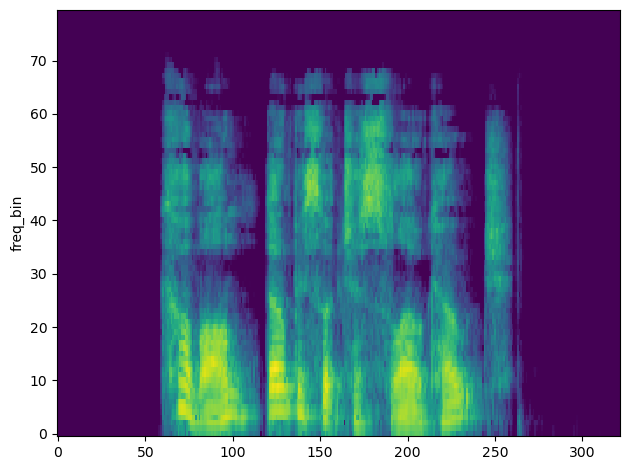

In [ ]:
fig, axis = plt.subplots(1, 1)
plot_spectrogram(melspec[0], ax=axis)

fig.tight_layout()
plt.show()

In [ ]:
out_encoder[0].detach().numpy().T.shape

(512, 161)

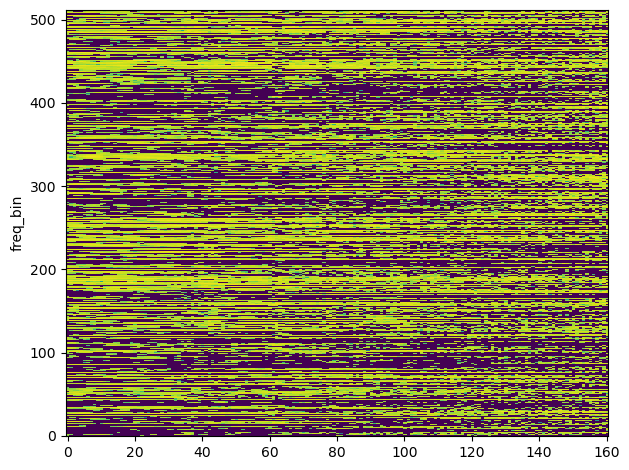

In [ ]:
fig, axis = plt.subplots(1, 1)

plot_spectrogram(out_encoder[0].detach().numpy().T, ax=axis)

fig.tight_layout()
plt.show()

In [2]:
from deepspeech import CommonVoiceDataset, DeepSpeechCC
from torch.utils.data import DataLoader
import torch

from tqdm import tqdm

ROOT_DIR = '/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/'

# Hyperparameters
lr = 1e-3
batch_size = 5
n_epochs = 10

# Load data
train_dataset = CommonVoiceDataset(root_dir=ROOT_DIR, mode='train')
val_dataset = CommonVoiceDataset(root_dir=ROOT_DIR, mode='val')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
vocab = torch.zeros(50257)
print(vocab.shape)
for melspecs, sentences in train_loader:

    ground_truth_matrix = torch.zeros(vocab_size)
     # print(melspecs.shape)
    # print(sentences)
 e,e,ee    tokens = tokenizer(sentences)['input_ids']
        
    lens = [len(token) for token in tokens]
    max_len = max(lens)
    for i in range(len(tokens)):
        tokens[i] = [tokenizer.bos_token_id] + tokens[i] + [tokenizer.eos_token_id] + [tokenizer.pad_token_id] * (max_len - len(tokens[i]))
        tokens[i] = vocab(tokens[i])
    out = torch.tensor(tokens)



    print(out.shape)


In [ ]:
[1] + [2]

In [ ]:
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, pipeline
import torch

model = GPT2LMHeadModel.from_pretrained('gpt2')
embedder = model.transformer.wte
vocab_size = model.config.vocab_size
print(vocab_size)
print(embedder)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '<|pad|>', 'bos_token': '<|sot|>', 'eos_token': '<|eot|>'})

print(special_tokens)

In [53]:
from deepspeech import CommonVoiceDataset, DeepSpeechCC
from torch.utils.data import DataLoader
import torch

from tqdm import tqdm

ROOT_DIR = '/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/'

# Hyperparameters
lr = 1e-3
batch_size = 5
n_epochs = 10

# Load data
train_dataset = CommonVoiceDataset(root_dir=ROOT_DIR, mode='train')
val_dataset = CommonVoiceDataset(root_dir=ROOT_DIR, mode='val')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [55]:
vocab = torch.zeros(50257)
print(vocab.shape)
print(tokenizer('<|endoftext|>')['input_ids'])
for melspecs, sentences in train_loader:
    print(melspecs.shape)
    #print(sentences)
    _tokens = tokenizer(sentences)['input_ids']
    lens = [len(_token) for _token in _tokens]
    max_len = max(lens)
    tokens = tokenizer(sentences, padding=True, return_tensors='pt')['input_ids']
        
    gt_matrix = torch.zeros(batch_size, vocab_size, max_len, dtype=torch.int)
    # [[1 2][1 1 1 1 1 ][ 1 2 3]] -> [[1 2 0 0 0][1 1 1 1 1][1 2 3 0 0]] -> 0 ; [1 2 0 0 0] ; : = 1
    # Loop over tokens in batch
    for i, seq in enumerate(tokens):
        # Set indices in gt_matrix to 1 at the positions specified by token indices
        gt_matrix[i, seq, range(max_len)] = 1

    out = embedder(gt_matrix)

    print(out.shape)

torch.Size([50257])
[50256]
torch.Size([5, 80, 626])
torch.Size([5, 50257, 15, 768])
torch.Size([5, 80, 626])
torch.Size([5, 50257, 24, 768])
torch.Size([5, 80, 626])
torch.Size([5, 50257, 14, 768])
torch.Size([5, 80, 626])


KeyboardInterrupt: 

In [22]:
a=torch.zeros(10, 5)

a[[1, 5, 0, 0, 0], range(5) ] = 1

print(a)

tensor([[0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])


In [62]:
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, pipeline
import torch

model = GPT2LMHeadModel.from_pretrained('gpt2')
embedder = model.transformer.wte
vocab_size = model.config.vocab_size
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
print(vocab_size)
print(embedder)
print(tokenizer.pad_token_id)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#tokenizer.add_special_tokens({'pad_token': '<|pad|>', 'bos_token': '<|sot|>', 'eos_token': '<|eot|>'})
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer.pad_token_id)

test = ['hello world' for _ in range(5)]
print(test)
tokens = tokenizer(test, padding=True, return_tensors='pt')['input_ids']
print(tokens)

test_out = [tokenizer.decode(token) for token in tokens]
print(test_out)


50257
Embedding(50257, 768)
None
50256
['hello world', 'hello world', 'hello world', 'hello world', 'hello world']
tensor([[31373,   995],
        [31373,   995],
        [31373,   995],
        [31373,   995],
        [31373,   995]])
['hello world', 'hello world', 'hello world', 'hello world', 'hello world']


In [36]:
from deepspeech import CommonVoiceDataset, DeepSpeechCC
from torch.utils.data import DataLoader
import torch

from tqdm import tqdm

ROOT_DIR = '/Users/rayaneeloudrhiri/dataset/cv-corpus-17.0-2024-03-15/en/'

# Hyperparameters
lr = 1e-3
batch_size = 5
n_epochs = 10

# Load data
train_dataset = CommonVoiceDataset(root_dir=ROOT_DIR, mode='train')
val_dataset = CommonVoiceDataset(root_dir=ROOT_DIR, mode='val')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [87]:
vocab = torch.zeros(50257)
print(vocab.shape)
for melspecs, sentences in train_loader:
    print(melspecs.shape)
    #print(sentences)

    tokens = tokenizer(sentences)['input_ids']
        
    lens = [len(token) for token in tokens]
    max_len = max(lens)
    for i in range(len(tokens)):
        #tokens[i] = [tokenizer.bos_token_id] + tokens[i] + [tokenizer.eos_token_id] + [tokenizer.pad_token_id] * (max_len - len(tokens[i]))
        tokens[i] = [tokens[i] + [tokenizer.eos_token_id] * (max_len - len(tokens[i]))
        tokens[i] = vocab(tokens[i])
    out = torch.tensor(tokens)

    print(out.shape)

torch.Size([50257])
torch.Size([5, 80, 626])


TypeError: 'Tensor' object is not callable

In [62]:
[1] + [2]

[1, 2]

In [1]:
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Config, GPT2Tokenizer, pipeline
import torch

model = GPT2LMHeadModel.from_pretrained('gpt2')
embedder = model.transformer.wte
vocab_size = model.config.vocab_size
print(vocab_size)
print(embedder)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#tokenizer.add_special_tokens({'pad_token': '<|pad|>', 'bos_token': '<|sot|>', 'eos_token': '<|eot|>'})

50257
Embedding(50257, 768)


NameError: name 'special_tokens' is not defined

In [56]:
import torch
import torch.nn as nn

# Configuration
batch_size = 2
vocab_size = 6
max_len = 100
pad_token_id = 5
audio_len = 20
# Class indices, assuming 5 is padding and correcting invalid indices (6) to padding as well
torch.manual_seed(0)
class_indices = torch.randint(0, vocab_size, (batch_size, max_len))  # last two indices are padding

# Example logits tensor with random data
class_logits = torch.randn(batch_size, max_len+1, vocab_size)
audio_logits = torch.randn(batch_size, audio_len-1, vocab_size)
logits = torch.cat((audio_logits, class_logits), dim=1)
logits_relevant = logits[:, audio_len-1:-1, :]

print(logits_relevant.shape, class_indices.shape)
# Cross-entropy loss setup with ignore_index to skip padding
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)

# Compute the loss, logits need to be (N, C, L) -> (N, L, C) for CrossEntropyLoss with batches
loss = loss_fn(logits_relevant.reshape(-1, vocab_size), class_indices.view(-1))

print("Cross-entropy loss:", loss.item())

torch.Size([2, 100, 6]) torch.Size([2, 100])
Cross-entropy loss: 2.182749032974243


In [2]:
from deepspeech import CommonVoiceDataset, DeepSpeechCC
model = DeepSpeechCC()
for name, param in model.named_parameters():
    print(name,param.requires_grad)


encoder.conv1.weight True
encoder.conv1.bias True
encoder.conv2.weight True
encoder.conv2.bias True
encoder.blocks.0.mha.heads.0.key.weight True
encoder.blocks.0.mha.heads.0.query.weight True
encoder.blocks.0.mha.heads.0.value.weight True
encoder.blocks.0.mha.heads.1.key.weight True
encoder.blocks.0.mha.heads.1.query.weight True
encoder.blocks.0.mha.heads.1.value.weight True
encoder.blocks.0.mha.heads.2.key.weight True
encoder.blocks.0.mha.heads.2.query.weight True
encoder.blocks.0.mha.heads.2.value.weight True
encoder.blocks.0.mha.heads.3.key.weight True
encoder.blocks.0.mha.heads.3.query.weight True
encoder.blocks.0.mha.heads.3.value.weight True
encoder.blocks.0.mha.heads.4.key.weight True
encoder.blocks.0.mha.heads.4.query.weight True
encoder.blocks.0.mha.heads.4.value.weight True
encoder.blocks.0.mha.heads.5.key.weight True
encoder.blocks.0.mha.heads.5.query.weight True
encoder.blocks.0.mha.heads.5.value.weight True
encoder.blocks.0.mha.heads.6.key.weight True
encoder.blocks.0.mha.